## Phase Retrieval Example

A complex field, contains amplitude and phase information:

O(x) = A(x) exp(iφ)

When it propagates through space and get captured by a camera, only its magnitude
will be observed. Gerchberg-Saxton algorithm enables obtaining the initial phase
term by measuring intensity-only images with different propagation settings e.g.,
different distances.

This code example, solves this phase retrieval problem by a set of simulated
diffraction intensity images obtained from different z values. This method could be
used to recover phase information in digital in-line holography.

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device = "/gpu:0"
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    device = "/cpu:0"

print("{device} is set-up and ready.".format(device=device))

import numpy as np
from skimage.restoration import unwrap_phase
from fringe.utils.io import import_image, import_image_seq
from fringe.utils.modifiers import ImageToArray, Normalize, MakeComplex, Map
from fringe.solvers.AngularSpectrum import AngularSpectrumSolver as AsSolver
from fringe.modules.PhaseRecovery import MultiDistancePhaseOptimizer as MDPO
from matplotlib import pyplot as plt

1 Physical GPUs, 1 Logical GPUs
/gpu:0 is set-up and ready.


Image imported from: images/sequence/0_300.tif

Forward solutions: 
A single intensity image results in infinite number solutions.



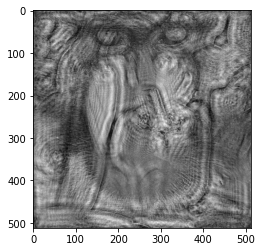

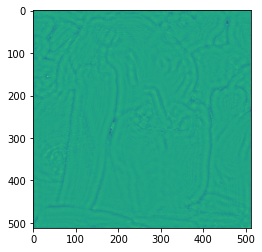

In [3]:

# Standardization
p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
bg = np.ones((512, 512))  # if there is no background, it should be estimated.
# Normalization
p2 = Normalize(background=bg)
p3 = Map(np.sqrt)
# Complex Field Generation
p4 = MakeComplex(set_as='amplitude', phase=0)

# Import with the settings
h_sample = import_image("images/sequence/0_300.tif", preprocessors=[p1, p2, p3, p4])
solver = AsSolver(shape=h_sample.shape, dr=1.12, is_batched=False, padding=None, backend="tensorflow")

z = -300
k = 2 * np.pi/532e-3
rec = solver.solve(input_=h_sample, k=k, z=z)
amp = np.abs(rec)
phase = unwrap_phase(np.angle(rec))

print("\nForward solutions: \nA single intensity image results in infinite number solutions.\n")

plt.imshow(amp, cmap='gray')
plt.show()
plt.imshow(phase, cmap='viridis')
plt.show()

### Phase Recovery
Phase recovery involves an iterative process though which, a local estimate of
phase will be achieved.

The algorithm requires:
- An intensity image sequence
- The wavenumber of the illumination light by which the image sequence
were captured
- An array of z values ordered in equivalence with the image sequence
- A diffraction solver class.

Image imported from: images/sequence/0_300.tif
Image imported from: images/sequence/1_350.tif
Image imported from: images/sequence/2_400.tif
Image imported from: images/sequence/3_450.tif
Image imported from: images/sequence/4_500.tif
Image imported from: images/sequence/5_550.tif
Image imported from: images/sequence/6_600.tif
Image imported from: images/sequence/7_650.tif
step: 0
step: 5
step: 10
step: 15
step: 20
step: 25
step: 30
step: 35
step: 40
step: 45
step: 50
step: 55
step: 60
step: 65
step: 70
step: 75
step: 80
step: 85
step: 90
step: 95

Obtained amplitude and phase images:



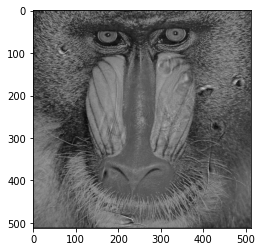

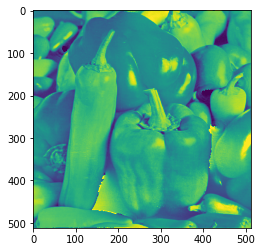

In [4]:

img_seq_paths = [
    "images/sequence/0_300.tif",
    "images/sequence/1_350.tif",
    "images/sequence/2_400.tif",
    "images/sequence/3_450.tif",
    "images/sequence/4_500.tif",
    "images/sequence/5_550.tif",
    "images/sequence/6_600.tif",
    "images/sequence/7_650.tif"
]

img_seq = import_image_seq(img_seq_paths, preprocessor=[p1, p2, p3, p4])

z_values = [-300.0, -350.0, -400.0, -450.0, -500.0, -550.0, -600.0, -650.0]
iterations = 100

solver = AsSolver(shape=img_seq[0].shape, dr=1.12, is_batched=False, padding=None, backend="tensorflow")

mdpo = MDPO(solver)
with tf.device(device):
    recovered_h = mdpo.optimize(img_seq, k,  z_values, iterations)
    amp = np.abs(recovered_h)
    phase = unwrap_phase(np.angle(recovered_h))
    phase += np.pi
    phase /= 2 * np.pi

print("\nObtained amplitude and phase images:\n")

plt.imshow(amp, cmap='gray')
plt.show()
plt.imshow(phase, cmap='viridis', vmin=0, vmax=1)
plt.show()
